### Machine Learning Assignment 3 - Wendy Gao

In [2]:
%matplotlib inline

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import LeaveOneOut,cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
import seaborn as sns

### Exercise 5

In [3]:
Default = pd.read_csv("Default.csv")

In [4]:
Default.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [59]:
X = Default.iloc[:,2:4]
y = Default['default']

In [13]:
# construct a linear regression model with no regularization
logit = LogisticRegression(C=1e5)

In [14]:
logit.fit(X,y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [20]:
preds = logit.predict(X)
preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

#### Using the validation set approach, estimate the test error of this model.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=10)

In [26]:
logit.fit(X_train,y_train)
train_preds = logit.predict(X_train)
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [39]:
test_probs = logit.predict_proba(X_test)[:,0]
test_pred = np.where(test_probs>0.5,"No","Yes")
test_pred

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], 
      dtype='|S3')

In [45]:
round(np.mean(test_pred!=y_test),4)

0.0377

* We have a 3.77% test error rate with the validation set approach.

#### Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.

In [51]:
error_rate = np.zeros(3)
randomindex = [12,34,56]
i=0
for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=randomindex[i])
    logit.fit(X_train,y_train)
    train_preds = logit.predict(X_train)
    test_probs = logit.predict_proba(X_test)[:,0]
    test_pred = np.where(test_probs>0.5,"No","Yes")
    error_rate[i] = round(np.mean(test_pred!=y_test),4)
    i = i+1

In [52]:
error_rate

array([ 0.036 ,  0.0297,  0.0327])

* Based on above results we could notice that the error rate can be variable, depending on which observations are included in the training set and which observations are included in the validation set.

#### Consider a logistic regression model that predicts the probability of default using income, balance, and a dummy variable for student

In [62]:
student = pd.get_dummies(Default['student'])
new_X = pd.concat([X,student],axis=1)
new_X.head()

,balance,income,No,Yes
0,729.526495,44361.625074,1,0
1,817.180407,12106.134700,0,1
2,1073.549164,31767.138947,1,0
3,529.250605,35704.493935,1,0
4,785.655883,38463.495879,1,0


In [66]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, train_size=0.7, random_state=12)
logit.fit(X_train,y_train)
train_preds = logit.predict(X_train)
test_probs = logit.predict_proba(X_test)[:,0]
test_pred = np.where(test_probs>0.5,"No","Yes")
round(np.mean(test_pred!=y_test),4)

0.036

* Hence, it doesn’t seem that adding the “student” dummy variable leads to a reduction in the validation set estimate of the test error rate.

### Exercise 8

In [75]:
np.random.seed(1)
y = np.random.normal(0,1,100)
x = np.random.normal(0,1,100)
y = x - 2*x**2 + np.random.normal(0,1,100)

The form of the linear model is
$$y=x - 2x^2+\epsilon$$

with $\epsilon$ follow a $N(0,1)$ random variable. Hence we have n = 100, p = 2.

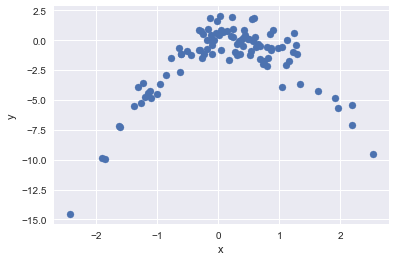

In [76]:
plt.scatter(x,y)
plt.xlabel("x")
plt.ylabel("y")

* The plot above suggests a curved relationship between x and y

In [118]:
np.random.seed(1)
df = pd.DataFrame([x, y])
df = df.transpose()
df.columns = ["x","y"]
x_data = df['x']
y_data = df['y']

(100,)

In [103]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/Users/gaoweijie/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [135]:
mod = smf.ols(formula='y ~ x', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     9.460
Date:                Wed, 25 Oct 2017   Prob (F-statistic):            0.00272
Time:                        14:39:59   Log-Likelihood:                -242.69
No. Observations:                 100   AIC:                             489.4
Df Residuals:                      98   BIC:                             494.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7609      0.280     -6.278      0.0

In [130]:
#Create a 100-fold cross validation set -- Leave one out
fold = df.shape[0]
kf=cross_validation.KFold(n=fold, n_folds=fold, shuffle=True, random_state=0)
      
RMSE = np.zeros((100))
i=0
for train_index, val_index in kf:
    X_train, X_val = x_data[train_index], x_data[val_index]
    y_train, y_val = y_data[train_index], y_data[val_index]
    mod = smf.ols(formula='y ~ x', data=X_train)
    res = mod.fit()
    yhat = res.predict(X_val)
    # calculate root mean square error
    RMSE[i]=np.sqrt(sum((y_val-yhat)**2))
    i=i+1

In [131]:
RMSE

array([  3.9424412 ,   1.19273124,   0.90789405,   0.6875414 ,
         0.77104362,   1.29248404,   2.37788304,   2.50060439,
         1.77581728,   3.97454808,   5.6779644 ,   4.83729627,
         0.64059328,   0.37762959,   1.03137232,   1.92240352,
         0.1850756 ,   6.52397857,   2.99452031,   0.47695128,
         0.69700072,   2.45363763,   3.06247982,   1.75694049,
         2.4095804 ,   3.48342902,   0.92256751,   0.25551088,
         1.39347944,   3.11025659,   1.28753391,   2.37006454,
         1.01799413,   7.37124239,  10.5377083 ,   1.36279802,
         0.75037003,   3.76298923,   1.1847463 ,   0.88355312,
         0.30791929,   1.83928457,   0.32429748,   1.42036575,
         2.06357201,   0.92111816,   4.03546206,   1.176879  ,
         1.12984737,   0.04253356,   1.46299185,   1.46115445,
         0.92141773,   0.45197651,   1.91988019,   1.19667749,
         0.24683394,   0.30383509,   5.69835134,   3.10056558,
         2.45545186,   1.18095502,   0.18532067,   2.30

In [132]:
np.mean(RMSE)

1.9816035224140938

In [134]:
#Create a 100-fold cross validation set -- Leave one out
from sklearn import cross_validation
fold = df.shape[0]
kf=cross_validation.KFold(n=fold, n_folds=fold, shuffle=True, random_state=0)
      
RMSE = np.zeros((100))
i=0
for train_index, val_index in kf:
    X_train, X_val = x_data[train_index], x_data[val_index]
    y_train, y_val = y_data[train_index], y_data[val_index]
    mod = smf.ols(formula='y ~ x + I(x ** 2.0)', data=X_train)
    res = mod.fit()
    yhat = res.predict(X_val)
    # calculate root mean square error
    RMSE[i]=np.sqrt(sum((y_val-yhat)**2))
    i=i+1

In [136]:
np.mean(RMSE)

0.77717863018349997

In [137]:
#Create a 100-fold cross validation set -- Leave one out
from sklearn import cross_validation
fold = df.shape[0]
kf=cross_validation.KFold(n=fold, n_folds=fold, shuffle=True, random_state=0)
      
RMSE = np.zeros((100))
i=0
for train_index, val_index in kf:
    X_train, X_val = x_data[train_index], x_data[val_index]
    y_train, y_val = y_data[train_index], y_data[val_index]
    mod = smf.ols(formula='y ~ x + I(x ** 2.0)+I(x ** 3.0)', data=X_train)
    res = mod.fit()
    yhat = res.predict(X_val)
    # calculate root mean square error
    RMSE[i]=np.sqrt(sum((y_val-yhat)**2))
    i=i+1

In [138]:
np.mean(RMSE)

0.77722996751398743

In [139]:
#Create a 100-fold cross validation set -- Leave one out
from sklearn import cross_validation
fold = df.shape[0]
kf=cross_validation.KFold(n=fold, n_folds=fold, shuffle=True, random_state=0)
      
RMSE = np.zeros((100))
i=0
for train_index, val_index in kf:
    X_train, X_val = x_data[train_index], x_data[val_index]
    y_train, y_val = y_data[train_index], y_data[val_index]
    mod = smf.ols(formula='y ~ x + I(x ** 2.0)+I(x ** 3.0)+I(x ** 4.0)', data=X_train)
    res = mod.fit()
    yhat = res.predict(X_val)
    # calculate root mean square error
    RMSE[i]=np.sqrt(sum((y_val-yhat)**2))
    i=i+1

In [140]:
np.mean(RMSE)

0.76717737545444076

In [ ]:
# Repeat (c) using another random seed

In [142]:
#Create a 100-fold cross validation set -- Leave one out
fold = df.shape[0]
kf=cross_validation.KFold(n=fold, n_folds=fold, shuffle=True, random_state=123)
      
RMSE = np.zeros((100))
i=0
for train_index, val_index in kf:
    X_train, X_val = x_data[train_index], x_data[val_index]
    y_train, y_val = y_data[train_index], y_data[val_index]
    mod = smf.ols(formula='y ~ x', data=X_train)
    res = mod.fit()
    yhat = res.predict(X_val)
    # calculate root mean square error
    RMSE[i]=np.sqrt(sum((y_val-yhat)**2))
    i=i+1
    
np.mean(RMSE)

1.9816035224140938

In [143]:
#Create a 100-fold cross validation set -- Leave one out
fold = df.shape[0]
kf=cross_validation.KFold(n=fold, n_folds=fold, shuffle=True, random_state=0)
      
RMSE = np.zeros((100))
i=0
for train_index, val_index in kf:
    X_train, X_val = x_data[train_index], x_data[val_index]
    y_train, y_val = y_data[train_index], y_data[val_index]
    mod = smf.ols(formula='y ~ x + I(x ** 2.0)', data=X_train)
    res = mod.fit()
    yhat = res.predict(X_val)
    # calculate root mean square error
    RMSE[i]=np.sqrt(sum((y_val-yhat)**2))
    i=i+1
    
np.mean(RMSE)

0.77717863018349997

In [144]:
#Create a 100-fold cross validation set -- Leave one out
fold = df.shape[0]
kf=cross_validation.KFold(n=fold, n_folds=fold, shuffle=True, random_state=0)
      
RMSE = np.zeros((100))
i=0
for train_index, val_index in kf:
    X_train, X_val = x_data[train_index], x_data[val_index]
    y_train, y_val = y_data[train_index], y_data[val_index]
    mod = smf.ols(formula='y ~ x + I(x ** 2.0)+I(x ** 3.0)', data=X_train)
    res = mod.fit()
    yhat = res.predict(X_val)
    # calculate root mean square error
    RMSE[i]=np.sqrt(sum((y_val-yhat)**2))
    i=i+1
    
np.mean(RMSE)

0.77722996751398743

In [145]:
#Create a 100-fold cross validation set -- Leave one out
fold = df.shape[0]
kf=cross_validation.KFold(n=fold, n_folds=fold, shuffle=True, random_state=0)
      
RMSE = np.zeros((100))
i=0
for train_index, val_index in kf:
    X_train, X_val = x_data[train_index], x_data[val_index]
    y_train, y_val = y_data[train_index], y_data[val_index]
    mod = smf.ols(formula='y ~ x + I(x ** 2.0)+I(x ** 3.0)+I(x ** 4.0)', data=X_train)
    res = mod.fit()
    yhat = res.predict(X_val)
    # calculate root mean square error
    RMSE[i]=np.sqrt(sum((y_val-yhat)**2))
    i=i+1
    
np.mean(RMSE)

0.76717737545444076

* The results above are identical to the results obtained in (c) since LOOCV evaluates n folds of a single observation.

* We may see that the LOOCV estimate for the test MSE is minimum for our last model, this is not surprising as when we increase the power and complexity of model we are tend to have a lower root mean square error, however in this case we are more likely to over-fitting the data. And as we could notice that the error decrease significantly when we introduce a quadratic term and since we saw plot in (b) that the relation between “x” and “y” is quadratic,so we might want to draw the conclution that the quadratic model is the best one.

In [147]:
mod = smf.ols(formula='y ~ x + I(x ** 2.0)+I(x ** 3.0)+I(x ** 4.0)', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     182.4
Date:                Wed, 25 Oct 2017   Prob (F-statistic):           1.13e-43
Time:                        15:03:01   Log-Likelihood:                -139.24
No. Observations:                 100   AIC:                             288.5
Df Residuals:                      95   BIC:                             301.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0866      0.144      0.600      

* The p-values show that the linear and quadratic terms are statistically significants and that the cubic and 4th degree terms are not statistically significants. This again proves that quadratic model is the best one as when we increase the power, we are tend to fit the noises.